In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np
import pickle

In [2]:
orbis22 = pd.read_csv('../data_collection/orbis22_clean.csv')
orbis22 = orbis22.drop('Unnamed: 0', axis=1)

In [3]:
# Get data
orbis = pd.read_csv('../data_collection/orbis_clean.csv')
orbis = orbis.drop('Unnamed: 0', axis=1)
gd = pd.read_csv('../reviews/all_df.csv')
gd = gd.drop('Unnamed: 0', axis=1)
industries = pd.read_csv('../data_collection/industries.csv')
industries = industries.drop('Unnamed: 0', axis=1)

<ipython-input-3-223cfa39998f>:4: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  gd = pd.read_csv('../reviews/all_df.csv')


In [4]:
industries = industries.rename(columns={"Nom de l'entreprise Latin alphabet": 'name',
                                       'Numéro Orbis': 'orbis_nbr',
                                       'BvD sectors': 'bvd_sector',
                                       'Code SIC (US) Code(s) Primaire(s)': 'primary_sic',
                                       'US SIC Principal, description textuelle': 'primary_sic_txt',
                                       'Code SIC (US) Code(s) Secondaire(s)': 'secundary_sic',
                                       'US SIC secondaire, description textuelle': 'secundary_sic_txt'})

In [5]:
# Exclude companies with less than 30 reviews
count_companies = gd.groupby('orbis_name')['review_id'].count()
gd = gd[gd['orbis_name'].isin(count_companies[count_companies >= 30].index)]

In [6]:
orbis22['orbis_name'] = orbis22['name']

In [7]:
# Complete dataset
# Merge financial and reviews and classification
orbis_gd = pd.merge(orbis, gd, left_on='name', right_on='orbis_name')
orbis_gd = pd.merge(orbis_gd, industries, on='orbis_nbr')
orbis_gd = pd.merge(orbis_gd, orbis22, on='orbis_name', how='left')

In [8]:
# Developement dataset!
#orbis_gd = orbis_gd.sample(frac =.10)

In [9]:
orbis_gd.shape

(567044, 268)

In [10]:
# Convert certain columns to numeric
def numerize_friend(string):
    if string == '"NEGATIVE"':
        return -1
    elif string == '"POSITIVE"':
        return 1
    else:
        return np.nan
    
def numerize_ceo(string):
    if string == '"DISAPPROVE"':
        return -1
    elif string == '"APPROVE"':
        return 1
    else:
        return np.nan
    
def numerize_outlook(string):
    if string == '"NEUTRAL"':
        return 0
    elif string == '"POSITIVE"':
        return 1
    elif string == '"NEGATIVE"':
        return -1
    else:
        return np.nan
    
orbis_gd['rating_recommend_friend'] = orbis_gd['rating_recommend_friend'].apply(numerize_friend)
orbis_gd['rating_ceo'] = orbis_gd['rating_ceo'].apply(numerize_ceo)
orbis_gd['rating_businessoutlook'] = orbis_gd['rating_businessoutlook'].apply(numerize_outlook)

In [11]:
# Remove industries with less than 1000 reviews
sector_counts = orbis_gd.groupby('bvd_sector')['review_id'].count()

to_remove = sector_counts[sector_counts < 1000]
to_remove.index
orbis_gd = orbis_gd[~orbis_gd['bvd_sector'].isin(to_remove.index)]

### Basic exploration

In [12]:
orbis_gd.shape

(566343, 268)

In [13]:
# Convert the Timestamp column to datetime format
orbis_gd['review_datetime'] = pd.to_datetime(orbis_gd['review_datetime'])

# Enough rating from mid 2016, remove before
orbis_gd = orbis_gd[orbis_gd['review_datetime'] > datetime(2017, 6, 1)]

# Diversity and inclusion starts only in mid 2020
orbis_gd.loc[orbis_gd['review_datetime'] < datetime(2021, 1, 1), 'rating_diversity_inclusion'] = np.nan

In [14]:
# Parsing went wrong for 237 - 6 = 231 reviews
print(len(orbis_gd['review_overall'].unique()))

# convert non-numeric values to NaN
orbis_gd['review_overall'] = pd.to_numeric(orbis_gd['review_overall'], errors='coerce')

# replace NaN values with a specific value, if desired
orbis_gd['review_overall'].fillna(value=np.nan, inplace=True)

print(len(orbis_gd['review_overall'].unique()))


237
6


In [15]:
monthly_ratings = orbis_gd.groupby(pd.Grouper(key='review_datetime', freq='M')).count()

<ipython-input-16-ff8e8cfb4fb0>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


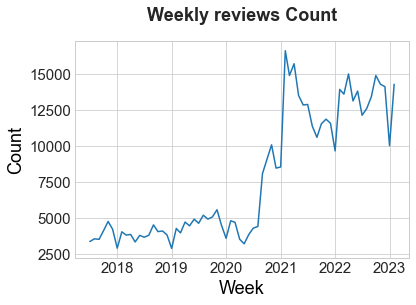

In [16]:
def apply_plot_style():
    # Define the style parameters
    plt.style.use('seaborn-whitegrid')
    plt.rcParams['figure.figsize'] = (10, 6)
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['font.size'] = 14
    plt.rcParams['axes.labelcolor'] = 'black'
    plt.rcParams['axes.labelsize'] = 18
    plt.rcParams['axes.titlesize'] = 18
    plt.rcParams['axes.titleweight'] = 'bold'
    plt.rcParams['axes.titlepad'] = 20.0
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15
    plt.rcParams['legend.fontsize'] = 14

# Example usage
apply_plot_style()

# Extract the relevant data for plotting
x = monthly_ratings[:-2].index
y = monthly_ratings[:-2]['name_x']

# Create a line plot using matplotlib
plt.plot(x, y)
plt.xlabel('Week')
plt.ylabel('Count')
plt.title('Weekly reviews Count')
plt.savefig('reviews_count.png')
plt.show()


In [17]:
# Look at the difference between currently employed ratings pre and post covid 

### Distribution of industries

In [18]:
# get sample data for chatgpt
#orbis_gd[:2].to_dict()

In [19]:
companies_per_sector = orbis_gd.groupby('bvd_sector')['name_x'].nunique().sort_values(ascending=False)
reviews_per_sector = orbis_gd.groupby('bvd_sector')['orbis_nbr'].count().reindex(companies_per_sector.index)
employees_per_company = orbis_gd.groupby(['bvd_sector', 'orbis_name'])['nbr_employees19'].mean() 
employees_per_sector = employees_per_company.groupby('bvd_sector').sum().reindex(companies_per_sector.index)
engagement_per_sector = reviews_per_sector / employees_per_sector

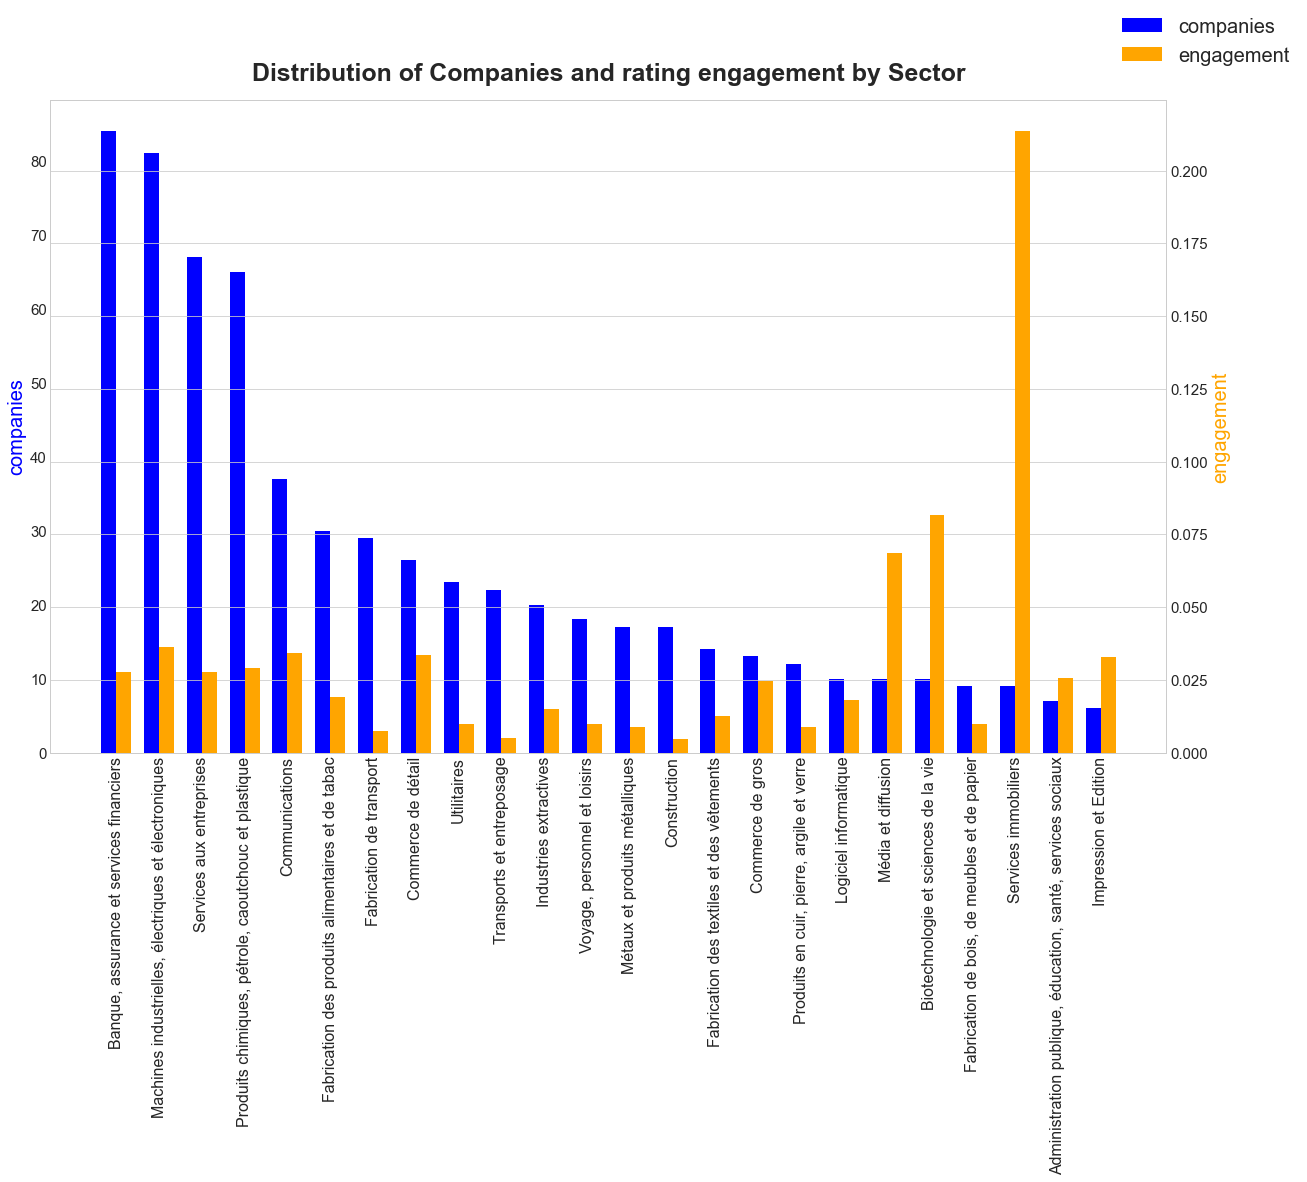

In [20]:
fig, ax1 = plt.subplots(figsize=(20, 12))

# set the width of each bar
width = 0.35

# create a range of x-values for the first bar chart
x1 = np.arange(len(companies_per_sector.index))

# plot the first bar chart
ax1.bar(x1, companies_per_sector.values, color='blue', width=width, label='companies')

# set the x-tick labels for the first bar chart
ax1.set_xticks(x1, fontsize=20)
ax1.set_xticklabels(companies_per_sector.index, rotation=90, fontsize=16)

# set the y-axis label for the first bar chart
ax1.set_ylabel('companies', color='blue', fontsize=20)
ax1.tick_params(axis='y', labelsize=15)
ax1.grid(False)

# create a range of x-values for the second bar chart, shifted by the width of each bar
x2 = x1 + width

# plot the second bar chart
ax2 = ax1.twinx()
ax2.bar(x2, engagement_per_sector.values, color='orange', width=width, label='engagement')

# set the x-tick labels for the second bar chart
ax2.set_xticks(x1 + width/2)
ax2.set_xticklabels(reviews_per_sector.index, rotation=90, fontsize=16)

# set the y-axis label for the second bar chart
ax2.set_ylabel('engagement', color='orange', fontsize=20)
ax2.tick_params(axis='y', labelsize=15)


# add legend
fig.legend(fontsize=20)
#ax1.legend(loc='upper left')
#ax2.legend(loc='upper right')

plt.title('Distribution of Companies and rating engagement by Sector', fontsize=25)
plt.savefig('engagement.png')
plt.show()


In [21]:
current_job = orbis_gd.groupby(pd.Grouper(key='review_datetime', freq='M'))['is_current_job'].value_counts(normalize=True)

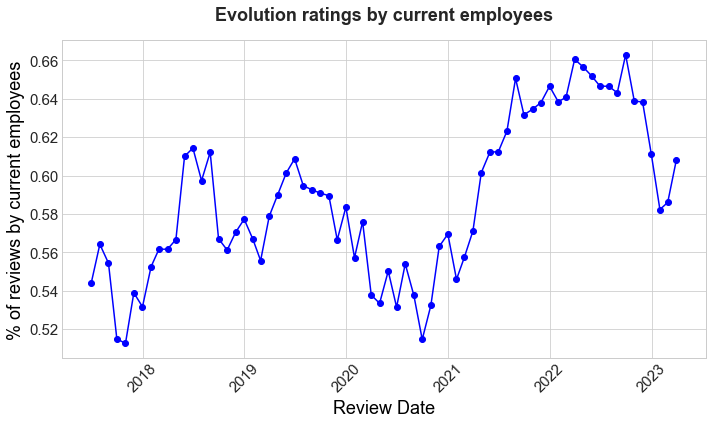

In [22]:
# Extract the True values percentages and their corresponding index (dates)
true_percentages = current_job.xs(True, level='is_current_job')
dates = true_percentages.index

# Plot the True values over time
plt.figure(figsize=(10, 6))
plt.plot(dates, true_percentages, marker='o', linestyle='-', color='b')
plt.xlabel('Review Date')
plt.ylabel('% of reviews by current employees')
plt.title('Evolution ratings by current employees')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig('is_current.png')
plt.show()


#appendix

### Ratings over time global

In [23]:
monthly_ratings = orbis_gd.groupby(pd.Grouper(key='review_datetime', freq='M'))['rating_worklifebalance',
                                                                        'rating_culture_values',
                                                                        'rating_diversity_inclusion',
                                                                        'rating_senior_leadership',
                                                                        'rating_career_opport',
                                                                        'rating_compensation_benefits',
                                                                        'review_overall',
                                                                        'rating_recommend_friend'].mean()
# Enough rating from mid 2016, remove before
monthly_ratings = monthly_ratings[monthly_ratings.index > datetime(2017, 6, 1)]

# Diversity and inclusion starts only in mid 2020
monthly_ratings.loc[monthly_ratings.index < datetime(2021, 1, 1), 'rating_diversity_inclusion'] = np.nan

<ipython-input-23-1e30b5329f01>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  monthly_ratings = orbis_gd.groupby(pd.Grouper(key='review_datetime', freq='M'))['rating_worklifebalance',


In [24]:
# Here first part: ratings

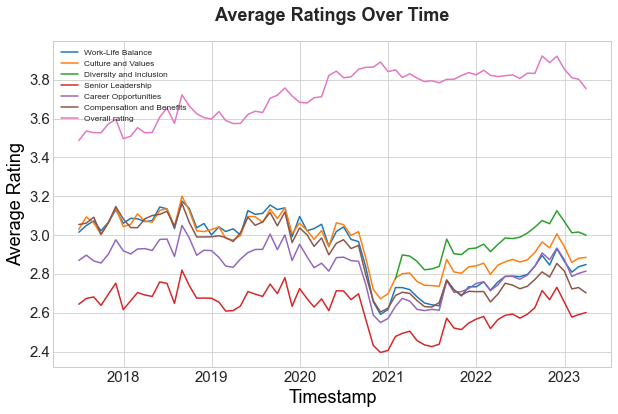

In [25]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(monthly_ratings.index, monthly_ratings['rating_worklifebalance'], label='Work-Life Balance')
ax.plot(monthly_ratings.index, monthly_ratings['rating_culture_values'], label='Culture and Values')
ax.plot(monthly_ratings.index, monthly_ratings['rating_diversity_inclusion'], label='Diversity and Inclusion')
ax.plot(monthly_ratings.index, monthly_ratings['rating_senior_leadership'], label='Senior Leadership')
ax.plot(monthly_ratings.index, monthly_ratings['rating_career_opport'], label='Career Opportunities')
ax.plot(monthly_ratings.index, monthly_ratings['rating_compensation_benefits'], label='Compensation and Benefits')
ax.plot(monthly_ratings.index, monthly_ratings['review_overall'], label='Overall rating')

ax.set_xlabel('Timestamp')
ax.set_ylabel('Average Rating')
ax.set_title('Average Ratings Over Time')
ax.legend(fontsize='smaller')  # Adjust the fontsize parameter as needed
plt.savefig('rating.png')
plt.show()


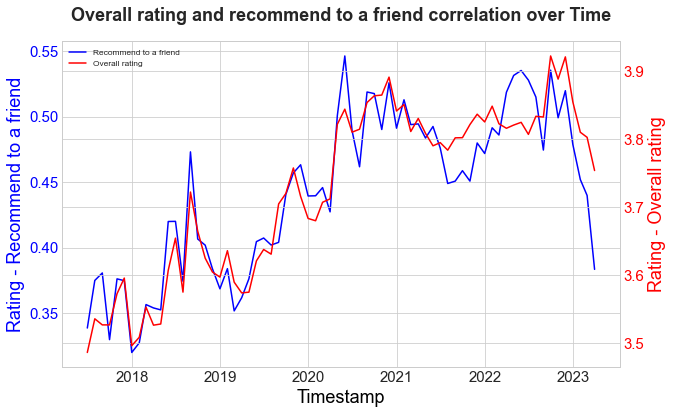

In [26]:
# Filter the data to start from mid-2017
monthly_ratings = monthly_ratings[monthly_ratings.index > datetime(2017, 6, 1)]

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the 'Recommend to a friend' series on the first y-axis (left)
ax1.plot(monthly_ratings.index, monthly_ratings['rating_recommend_friend'], label='Recommend to a friend', color='b')
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Rating - Recommend to a friend', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a secondary y-axis
ax2 = ax1.twinx()

# Plot the 'Overall rating' series on the second y-axis (right)
ax2.plot(monthly_ratings.index, monthly_ratings['review_overall'], label='Overall rating', color='r')
ax2.set_ylabel('Rating - Overall rating', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Combine the legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left', fontsize='smaller')

# Set the title
ax1.set_title('Overall rating and recommend to a friend correlation over Time')

# Save and display the plot
plt.savefig('rating_rec.png')
plt.show()

## Rating by industry over time

In [27]:
ratings = ['rating_worklifebalance',
        'rating_culture_values',
        'rating_senior_leadership',
        'rating_career_opport',
        'rating_compensation_benefits']

In [28]:
sectors = orbis_gd['bvd_sector'].unique()

In [29]:
monthly_average_industry = {}
for sector in sectors:
    sector_data = orbis_gd[orbis_gd['bvd_sector'] == sector]
    monthly_average_industry[sector] = sector_data.groupby(pd.Grouper(key='review_datetime', freq='M'))[ratings].mean()

In [30]:
# for j in range(1,5):
#     fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20, 20))

#     for rating in ratings:
#         for i, sector in enumerate(sectors[(j-1)*6:j*6]):
#             row = i // 2
#             col = i % 2
#             ax = axs[row, col]

#             ax.plot(monthly_average_industry[sector].index, monthly_average_industry[sector][rating], label=rating)
#             ax.set_xlabel('Timestamp')
#             ax.set_ylabel('Average rating')
#             ax.set_title(f'{sector} - Average Ratings Over Time')
#             ax.set_ylim(1, 4)
#     ax.legend()
#     plt.tight_layout()
#     plt.savefig(f'rating_drill{j}.png')
#     plt.show()

A lot of collinearity.

In [31]:
orbis_gd['bvd_sector'].value_counts()

Services aux entreprises                                       96438
Machines industrielles, électriques et électroniques           79594
Banque, assurance et services financiers                       66008
Produits chimiques, pétrole, caoutchouc et plastique           54989
Commerce de détail                                             52063
Communications                                                 45895
Fabrication des produits alimentaires et de tabac              25432
Fabrication de transport                                       20740
Voyage, personnel et loisirs                                   16827
Logiciel informatique                                           9414
Industries extractives                                          9304
Utilitaires                                                     8671
Fabrication des textiles et des vêtements                       8453
Transports et entreposage                                       8203
Commerce de gros                  

Does not seem to be due by insufficent sample size.

Let's get this information into a table:

In [32]:
# Average rating per period per industry

## For each industry, each rating take the 90 and 10th percentile and get the difference to see for each period each indsutry how this went

In [33]:
def get_period(date):
    if datetime(2021, 8, 1) >= date >= datetime(2020, 3, 18):
        return 2
    elif datetime(2021, 8, 1) < date:
        return 3
    else:
        return 1

In [34]:
orbis_gd['period'] = orbis_gd['review_datetime'].apply(get_period)

In [35]:
# Get average rating by company by period
review_period = orbis_gd.groupby(['orbis_name', 'bvd_sector', 'period'])['review_overall'].agg(['mean', 'count'])

In [36]:
review_period

mean  \
orbis_name                bvd_sector                               period             
3I GROUP PLC              Banque, assurance et services financiers 1       3.937500   
                                                                   2       4.000000   
                                                                   3       4.375000   
A P MOLLER-MAERSK A/S     Transports et entreposage                2       4.048643   
                                                                   3       4.158699   
...                                                                             ...   
ZALANDO SE                Commerce de détail                       2       3.929360   
                                                                   3       3.891348   
ZURICH INSURANCE GROUP AG Banque, assurance et services financiers 1       2.952381   
                                                                   2       3.562500   
                                                                   3       3.172414   

                                                                           count  
orbis_name                bvd_sector                               period         
3I GROUP PLC              Banque, assurance et services financiers 1          16  
                                                                   2           7  
                                                                   3          16  
A P MOLLER-MAERSK A/S     Transports et entreposage                2         884  
                                                                   3        1506  
...                                                                          ...  
ZALANDO SE                Commerce de détail                       2         453  
                                                                   3         497  
ZURICH INSURANCE GROUP AG Banque, assurance et services financiers 1          21  
                                                                   2          16  
                                                                   3          29  

[1833 rows x 2 columns]

In [37]:
sector_period = orbis_gd.groupby(['bvd_sector', 'period'])['review_overall'].agg(['mean', 'count'])

In [38]:
sector_period
# with open('sector_rating.tex','w') as tf:
#     tf.write(sector_period.to_latex())

#appendix

mean  count
bvd_sector                                         period                 
Administration publique, éducation, santé, serv... 1       3.672913   1174
                                                   2       3.708180   1357
                                                   3       3.789602   2058
Banque, assurance et services financiers           1       3.572303  16182
                                                   2       3.811939  18930
...                                                             ...    ...
Utilitaires                                        2       3.651815   2424
                                                   3       3.786480   3639
Voyage, personnel et loisirs                       1       3.473385   4396
                                                   2       3.679081   5048
                                                   3       3.523906   7383

[72 rows x 2 columns]

In [39]:
# Remove if too little reviews in a given period
review_period = review_period[review_period['count'] > 20]

In [40]:
# Companies by industry
company_counts = review_period.groupby('bvd_sector').size().rename('Company Count')

In [41]:
#add just the grades percentile to know where the differen is coming from 

In [42]:
# Build df with 90-10th and 75-25th company rating percentile within each industry for each period
variability_desc = review_period.pivot_table(values='mean', 
                                             index='bvd_sector', 
                                             columns='period', 
                                             aggfunc=lambda x: ((np.percentile(x, 90) - np.percentile(x, 10)).round(2), 
                                                                (np.percentile(x, 75) - np.percentile(x, 25)).round(2)))
variability_desc = variability_desc.rename(columns={1: 'Pre-lockdown (90th-10th, 75th-25th)', 2: 'During lockdown', 3: 'Post-lockdown'})

In [43]:
variability = variability_desc.merge(company_counts, left_index=True, right_index=True)
variability = variability.sort_values('Company Count', ascending=False)
variability

#appendix

Pre-lockdown (90th-10th, 75th-25th)  \
bvd_sector                                                                               
Machines industrielles, électriques et électron...                        (1.03, 0.69)   
Banque, assurance et services financiers                                  (0.85, 0.46)   
Services aux entreprises                                                   (0.94, 0.5)   
Produits chimiques, pétrole, caoutchouc et plas...                         (0.76, 0.4)   
Communications                                                            (0.94, 0.48)   
Fabrication de transport                                                  (0.67, 0.42)   
Fabrication des produits alimentaires et de tabac                          (0.9, 0.44)   
Commerce de détail                                                        (0.91, 0.32)   
Transports et entreposage                                                 (1.08, 0.69)   
Utilitaires                                                               (0.59, 0.41)   
Voyage, personnel et loisirs                                              (0.94, 0.59)   
Industries extractives                                                    (0.55, 0.35)   
Métaux et produits métalliques                                             (0.5, 0.22)   
Fabrication des textiles et des vêtements                                  (0.79, 0.6)   
Construction                                                              (1.15, 0.39)   
Commerce de gros                                                           (0.6, 0.16)   
Produits en cuir, pierre, argile et verre                                 (0.68, 0.52)   
Logiciel informatique                                                      (1.04, 0.4)   
Média et diffusion                                                        (0.62, 0.21)   
Fabrication de bois, de meubles et de papier                              (0.68, 0.28)   
Administration publique, éducation, santé, serv...                         (0.48, 0.2)   
Impression et Edition                                                     (0.66, 0.52)   
Services immobiliers                                                      (0.86, 0.71)   
Biotechnologie et sciences de la vie                                      (0.37, 0.23)   

                                                   During lockdown  \
bvd_sector                                                           
Machines industrielles, électriques et électron...    (0.81, 0.43)   
Banque, assurance et services financiers               (0.55, 0.3)   
Services aux entreprises                              (0.85, 0.32)   
Produits chimiques, pétrole, caoutchouc et plas...    (0.53, 0.28)   
Communications                                         (0.8, 0.49)   
Fabrication de transport                              (0.85, 0.39)   
Fabrication des produits alimentaires et de tabac     (0.63, 0.41)   
Commerce de détail                                    (1.02, 0.36)   
Transports et entreposage                             (0.76, 0.43)   
Utilitaires                                           (0.69, 0.38)   
Voyage, personnel et loisirs                          (0.69, 0.52)   
Industries extractives                                (0.54, 0.23)   
Métaux et produits métalliques                         (0.5, 0.36)   
Fabrication des textiles et des vêtements             (0.51, 0.33)   
Construction                                          (1.07, 0.65)   
Commerce de gros                                      (0.58, 0.37)   
Produits en cuir, pierre, argile et verre             (0.52, 0.26)   
Logiciel informatique                                 (0.55, 0.28)   
Média et diffusion                                    (0.67, 0.44)   
Fabrication de bois, de meubles et de papier          (0.82, 0.41)   
Administration publique, éducation, santé, serv...    (0.85, 0.61)   
Impression et Edition                                 (0.73, 0.37)   
Services immobiliers          

In [44]:
with open('75_25.tex','w') as tf:
    tf.write(variability.to_latex())

<ipython-input-44-a401a1ef671e>:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tf.write(variability.to_latex())


Table showing number of firms, number of reviews, mean, median, max and min. amount of reviews and decide at how much to exclude

In [45]:
descriptable1 = orbis_gd.groupby('bvd_sector').agg(
                        review_count = ('review_id', 'count'),
                        companies = ('name_x', 'nunique'),
                        overall = ('review_overall', 'mean'),
                        worklife = ('rating_worklifebalance', 'mean'),
                        culture = ('rating_culture_values', 'mean')
                            ).sort_values(by=['review_count'], ascending=False)
descriptable2 = orbis_gd.groupby('bvd_sector').agg(
                        review_count = ('review_id', 'count'),
                        leadership = ('rating_senior_leadership', 'mean'),
                        opports = ('rating_career_opport', 'mean'),
                        comps = ('rating_compensation_benefits', 'mean'),
                        inclus = ('rating_diversity_inclusion', 'mean')
                            ).sort_values(by=['review_count'], ascending=False)
descriptable3 = orbis_gd.groupby('bvd_sector').agg(
                        review_count = ('review_id', 'count'),
                        friend = ('rating_recommend_friend', 'mean'),
                        ceo = ('rating_ceo', 'mean'),
                        outlook = ('rating_businessoutlook', 'mean')
                            ).sort_values(by=['review_count'], ascending=False)

# Function to round the means to one decimal place
def round_mean(value):
    return round(value, 1)

# Apply the round_mean function to the mean columns in each DataFrame
descriptable1['overall'] = descriptable1['overall'].apply(round_mean)
descriptable1['worklife'] = descriptable1['worklife'].apply(round_mean)
descriptable1['culture'] = descriptable1['culture'].apply(round_mean)

descriptable2['leadership'] = descriptable2['leadership'].apply(round_mean)
descriptable2['opports'] = descriptable2['opports'].apply(round_mean)
descriptable2['comps'] = descriptable2['comps'].apply(round_mean)
descriptable2['inclus'] = descriptable2['inclus'].apply(round_mean)

descriptable3['friend'] = descriptable3['friend'].apply(round_mean)
descriptable3['ceo'] = descriptable3['ceo'].apply(round_mean)
descriptable3['outlook'] = descriptable3['outlook'].apply(round_mean)


with open('descriptable1.tex','w') as tf:
    tf.write(descriptable1.to_latex())
with open('descriptable2.tex','w') as tf:
    tf.write(descriptable2.to_latex())
with open('descriptable3.tex','w') as tf:
    tf.write(descriptable3.to_latex())

<ipython-input-45-e68addb98fdd>:42: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tf.write(descriptable1.to_latex())
<ipython-input-45-e68addb98fdd>:44: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tf.write(descriptable2.to_latex())
<ipython-input-45-e68addb98fdd>:46: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is rec

## Text

In [46]:
# # Combine pros and cons columns into a single text column
# text = pd.DataFrame()
# text['rating'] = orbis_gd['review_overall']
# text['pros'] = orbis_gd['pros']
# text['cons'] = orbis_gd['cons']
# text['text'] = text['pros'] + ' ' + text['cons']
# text['period'] = orbis_gd['period']

# # Drop rows with missing values
# text.dropna(inplace=True)

# import string
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
# from nltk.stem import WordNetLemmatizer

# def normalize_text(doc):
#     # Remove newlines and carriage returns
#     doc = doc.replace('\r', ' ').replace('\n', ' ')

#     # Convert to lowercase
#     lower = doc.lower()

#     # Remove punctuation
#     no_punct = lower.translate(str.maketrans('', '', string.punctuation))

#     # Tokenize the text
#     tokens = word_tokenize(no_punct)

#     # Remove stopwords
#     stop_words = set(stopwords.words('english'))
#     filtered_tokens = [word for word in tokens if word.lower() not in stop_words]

#     # Lemmatization
#     lemmatizer = WordNetLemmatizer()
#     lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]

#     # Join the lemmatized tokens into a single string
#     normalized_text = ' '.join(lemmatized_tokens)

#     return normalized_text

# # Normalize
# text['pros_lemma'] = text['pros'].apply(normalize_text)
# text['cons_lemma'] = text['cons'].apply(normalize_text)

file_path = 'text2.pickle'
# # Write pickle
# with open(file_path, 'wb') as f:
#     pickle.dump(text, f)
# Read pickle
with open(file_path, 'rb') as f:
    text = pickle.load(f)

In [47]:
text.head()

rating                                               pros  \
0     3.0                   Four days a week Lunch allowance   
1     4.0            Good package , nice working environment   
2     3.0  It’s a good place for learning about how to do...   
3     4.0  Good employee benefits Company training Year e...   
4     5.0  Great management. Beautiful products. Excellen...   

                                                cons  \
0               long hours Long days Poor management   
1      Manual works, not have much systematic system   
2                    Too much politics and formality   
3             Limited Salary increment for employees   
4  There are only a few cons. Mainly in Nottingha...   

                                                text  period  \
0  Four days a week Lunch allowance long hours Lo...       3   
1  Good package , nice working environment Manual...       3   
2  It’s a good place for learning about how to do...       3   
3  Good employee benefits Company training Year e...       3   
4  Great management. Beautiful products. Excellen...       3   

                                          pros_lemma  \
0                      four day week lunch allowance   
1              good package nice working environment   
2  ’ good place learning presentation ’ make diff...   
3  good employee benefit company training year en...   
4  great management beautiful product excellent t...   

                                          cons_lemma  
0                 long hour long day poor management  
1                 manual work much systematic system  
2                            much politics formality  
3                  limited salary increment employee  
4  con mainly nottingham would great givenchy ski...

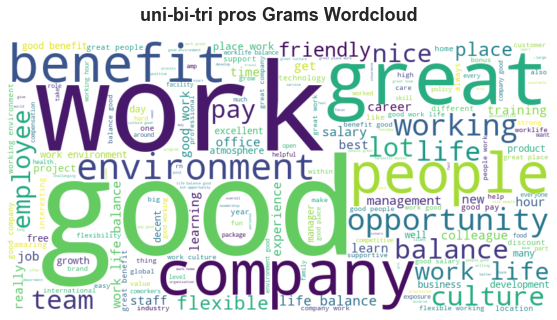

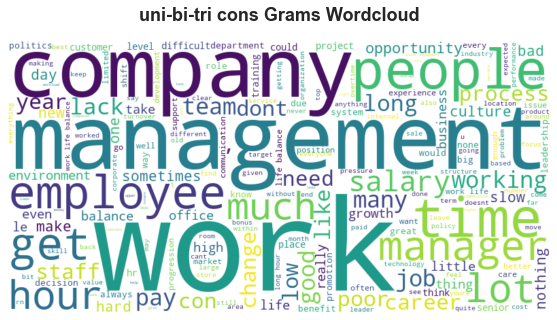

In [50]:
from nltk import ngrams
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Join the lemmatized pros into a single string
pros_text_p1 = ' '.join(text['pros_lemma'][text['period'] == 1])
pros_text_p2 = ' '.join(text['pros_lemma'][text['period'] == 2])
pros_text_p3 = ' '.join(text['pros_lemma'][text['period'] == 3])
cons_text_p1 = ' '.join(text['cons_lemma'][text['period'] == 1])
cons_text_p2 = ' '.join(text['cons_lemma'][text['period'] == 2])
cons_text_p3 = ' '.join(text['cons_lemma'][text['period'] == 3])

# Join the lemmatized pros into a single string
pros_text = ' '.join(text['pros_lemma'])
cons_text = ' '.join(text['cons_lemma'])

all_grams = {
    'grams_pros': list(ngrams(pros_text_p1.split(), 1)),
    'grams_cons': list(ngrams(cons_text_p1.split(), 1)),
    'bigrams_pros': list(ngrams(pros_text_p1.split(), 2)),
    'bigrams_cons': list(ngrams(cons_text_p1.split(), 2)),
    'trigrams_pros': list(ngrams(pros_text_p1.split(), 3)),
    'trigrams_cons': list(ngrams(cons_text_p1.split(), 3))
}

# Merge the lists
all_grams_merged = {
    'all_grams_pros': all_grams['grams_pros'] + all_grams['bigrams_pros'] + all_grams['trigrams_pros'],
    'all_grams_cons': all_grams['grams_cons'] + all_grams['bigrams_cons'] + all_grams['trigrams_cons']
}

# Function to plot wordcloud
def plot_wordcloud(data, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white')
    wordcloud.generate_from_frequencies(dict(data))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Create grams and bigrams wordclouds for pros
def list_to_wordcloud(plot_name, grams):
    grams_dict = dict()
    for gram in grams:
        gram_str = ' '.join(gram)  # Convert the tuple to a string
        if gram_str in grams_dict:
            grams_dict[gram_str] += 1
        else:
            grams_dict[gram_str] = 1
    
    plot_wordcloud(grams_dict, f'{plot_name} Grams Wordcloud')

list_to_wordcloud('uni-bi-tri pros', all_grams_merged['all_grams_pros'])
list_to_wordcloud('uni-bi-tri cons', all_grams_merged['all_grams_cons'])

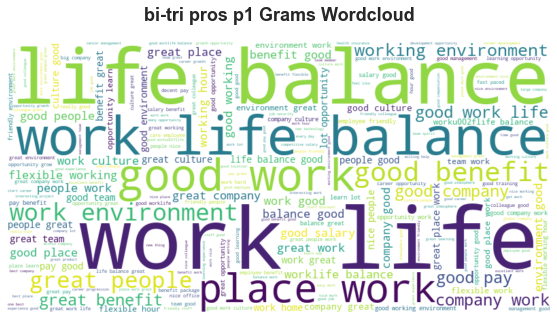

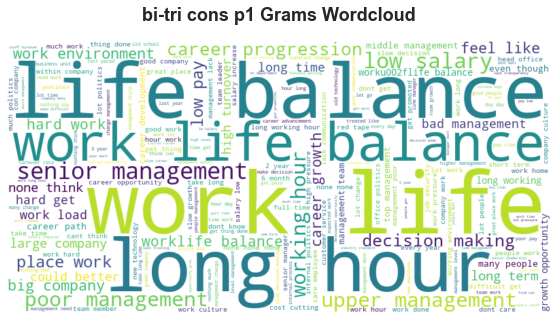

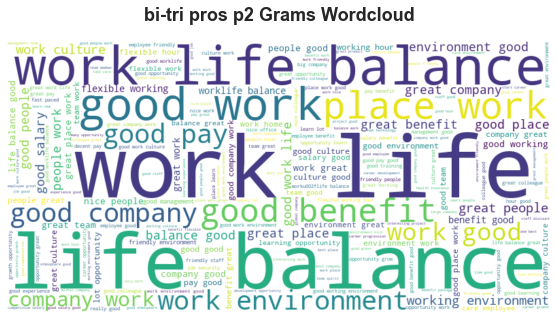

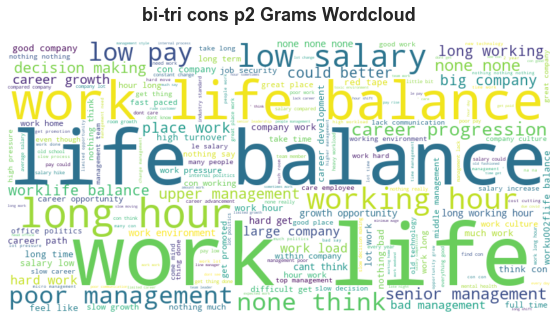

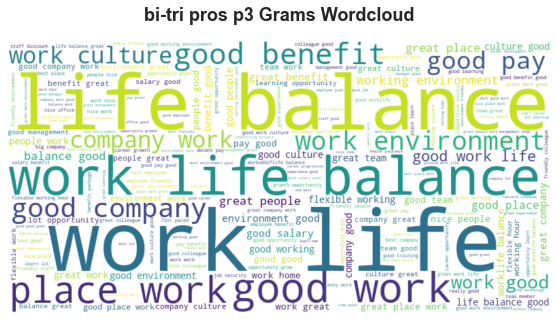

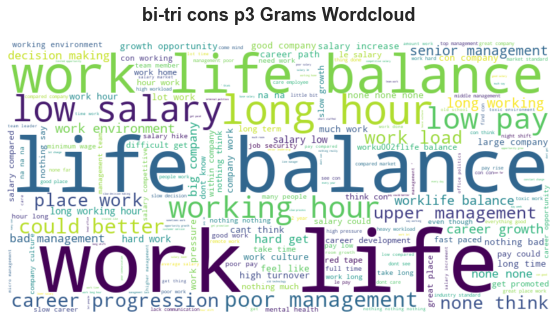

In [51]:

# Extract grams and bigrams
all_grams = {
            'bigrams_pros_p1': list(ngrams(pros_text_p1.split(), 2)),
            'bigrams_cons_p1': list(ngrams(cons_text_p1.split(), 2)),
            'trigrams_pros_p1': list(ngrams(pros_text_p1.split(), 3)),
            'trigrams_cons_p1': list(ngrams(cons_text_p1.split(), 3)),
           
            'bigrams_pros_p2': list(ngrams(pros_text_p2.split(), 2)),
            'bigrams_cons_p2': list(ngrams(cons_text_p2.split(), 2)),
            'trigrams_pros_p2': list(ngrams(pros_text_p2.split(), 3)),
            'trigrams_cons_p2': list(ngrams(cons_text_p2.split(), 3)),
           
            'bigrams_pros_p3': list(ngrams(pros_text_p3.split(), 2)),
            'bigrams_cons_p3': list(ngrams(cons_text_p3.split(), 2)),
            'trigrams_pros_p3': list(ngrams(pros_text_p3.split(), 3)),
            'trigrams_cons_p3': list(ngrams(cons_text_p3.split(), 3))}



# Merge the lists
all_grams_merged = {
    'all_grams_pros1': all_grams['bigrams_pros_p1'] + all_grams['trigrams_pros_p1'],
    'all_grams_cons1': all_grams['bigrams_cons_p1'] + all_grams['trigrams_cons_p1'],
    'all_grams_pros2': all_grams['bigrams_pros_p2'] + all_grams['trigrams_pros_p2'],
    'all_grams_cons2': all_grams['bigrams_cons_p2'] + all_grams['trigrams_cons_p2'],
    'all_grams_pros3': all_grams['bigrams_pros_p3'] + all_grams['trigrams_pros_p3'],
    'all_grams_cons3': all_grams['bigrams_cons_p3'] + all_grams['trigrams_cons_p3'],
    
}

# Function to plot wordcloud
def plot_wordcloud(data, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white')
    wordcloud.generate_from_frequencies(dict(data))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Create grams and bigrams wordclouds for pros
def list_to_wordcloud(plot_name, grams):
    grams_dict = dict()
    for gram in grams:
        gram_str = ' '.join(gram)  # Convert the tuple to a string
        if gram_str in grams_dict:
            grams_dict[gram_str] += 1
        else:
            grams_dict[gram_str] = 1
    
    plot_wordcloud(grams_dict, f'{plot_name} Grams Wordcloud')
    return grams_dict

pros_dict = list_to_wordcloud('bi-tri pros p1', all_grams_merged['all_grams_pros1'])
cons_dict = list_to_wordcloud('bi-tri cons p1', all_grams_merged['all_grams_cons1'])
pros_dict = list_to_wordcloud('bi-tri pros p2', all_grams_merged['all_grams_pros2'])
cons_dict = list_to_wordcloud('bi-tri cons p2', all_grams_merged['all_grams_cons2'])
pros_dict = list_to_wordcloud('bi-tri pros p3', all_grams_merged['all_grams_pros3'])
cons_dict = list_to_wordcloud('bi-tri cons p3', all_grams_merged['all_grams_cons3'])

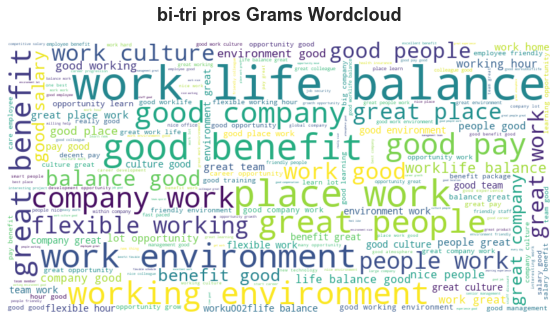

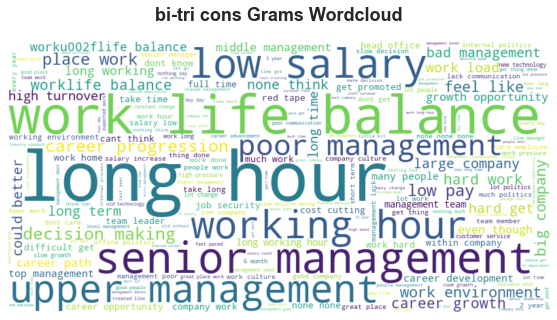

In [113]:
# Join the lemmatized pros into a single string
pros_text = ' '.join(text['pros_lemma'])
cons_text = ' '.join(text['cons_lemma'])


all_grams = {
    'bigrams_pros': list(ngrams(pros_text_p1.split(), 2)),
    'bigrams_cons': list(ngrams(cons_text_p1.split(), 2)),
    'trigrams_pros': list(ngrams(pros_text_p1.split(), 3)),
    'trigrams_cons': list(ngrams(cons_text_p1.split(), 3))
}

# Merge the lists
all_grams_merged = {
    'all_grams_pros': [gram for gram in all_grams['bigrams_pros'] + all_grams['trigrams_pros'] if gram != ('work', 'life') and gram != ('life', 'balance') and gram != ('good', 'work', 'life') and gram != ('good', 'work')],
    'all_grams_cons': [gram for gram in all_grams['bigrams_cons'] + all_grams['trigrams_cons'] if gram != ('work', 'life') and gram != ('life', 'balance') and gram != ('good', 'work', 'life') and gram != ('good', 'work')]
}

# Function to plot wordcloud
def plot_wordcloud(data, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white')
    wordcloud.generate_from_frequencies(dict(data))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.savefig(f'{title}.png')
    plt.show()

# Create grams and bigrams wordclouds for pros
def list_to_wordcloud(plot_name, grams):
    grams_dict = dict()
    for gram in grams:
        gram_str = ' '.join(gram)  # Convert the tuple to a string
        if gram_str in grams_dict:
            grams_dict[gram_str] += 1
        else:
            grams_dict[gram_str] = 1
    
    plot_wordcloud(grams_dict, f'{plot_name} Grams Wordcloud')

list_to_wordcloud('bi-tri pros', all_grams_merged['all_grams_pros'])
list_to_wordcloud('bi-tri cons', all_grams_merged['all_grams_cons'])

In [53]:
# with open('text.tex','w') as tf:
#     tf.write(text.head().to_latex())

In [54]:
from nltk import ngrams

# Join the lemmatized pros into a single string
pros_text_p1 = ' '.join(text['pros_lemma'][text['period'] == 1])
pros_text_p2 = ' '.join(text['pros_lemma'][text['period'] == 2])
pros_text_p3 = ' '.join(text['pros_lemma'][text['period'] == 3])
cons_text_p1 = ' '.join(text['cons_lemma'][text['period'] == 1])
cons_text_p2 = ' '.join(text['cons_lemma'][text['period'] == 2])
cons_text_p3 = ' '.join(text['cons_lemma'][text['period'] == 3])


# Extract grams and bigrams
all_grams = {'grams_pros_p1': ngrams(pros_text_p1.split(), 1),
            'grams_cons_p1': ngrams(cons_text_p1.split(), 1),
            'bigrams_pros_p1': ngrams(pros_text_p1.split(), 2),
            'bigrams_cons_p1': ngrams(cons_text_p1.split(), 2),
            'trigrams_pros_p1': ngrams(pros_text_p1.split(), 3),
            'trigrams_cons_p1': ngrams(cons_text_p1.split(), 3),
            'grams_pros_p2': ngrams(pros_text_p2.split(), 1),
            'grams_cons_p2': ngrams(cons_text_p2.split(), 1),
            'bigrams_pros_p2': ngrams(pros_text_p2.split(), 2),
            'bigrams_cons_p2': ngrams(cons_text_p2.split(), 2),
            'trigrams_pros_p2': ngrams(pros_text_p2.split(), 3),
            'trigrams_cons_p2': ngrams(cons_text_p2.split(), 3),
            'grams_pros_p3': ngrams(pros_text_p3.split(), 1),
            'grams_cons_p3': ngrams(cons_text_p3.split(), 1),
            'bigrams_pros_p3': ngrams(pros_text_p3.split(), 2),
            'bigrams_cons_p3': ngrams(cons_text_p3.split(), 2),
            'trigrams_pros_p3': ngrams(pros_text_p3.split(), 3),
            'trigrams_cons_p3': ngrams(cons_text_p3.split(), 3)}

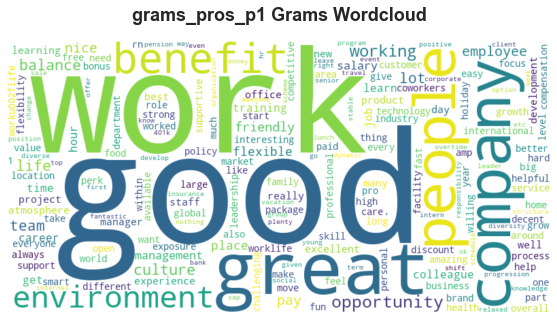

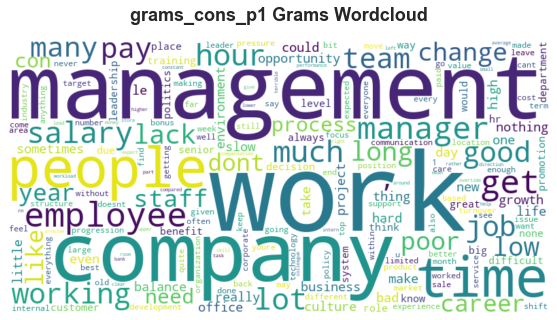

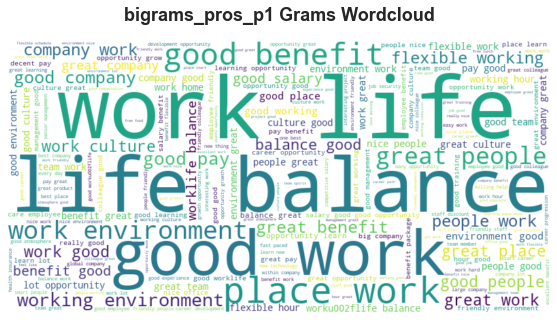

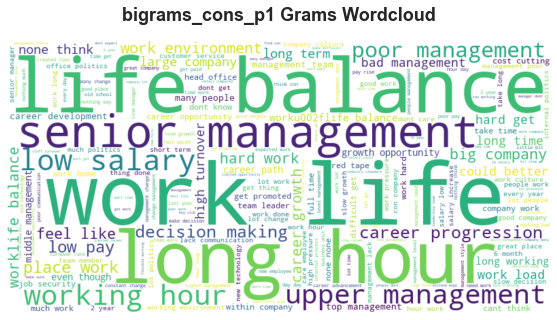

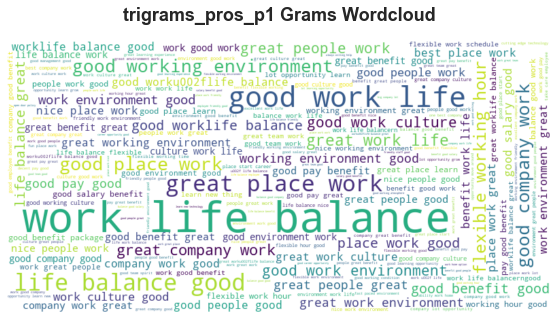

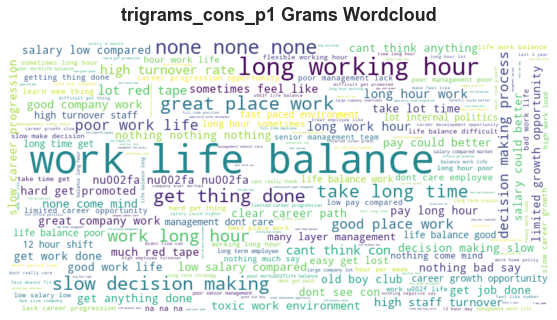

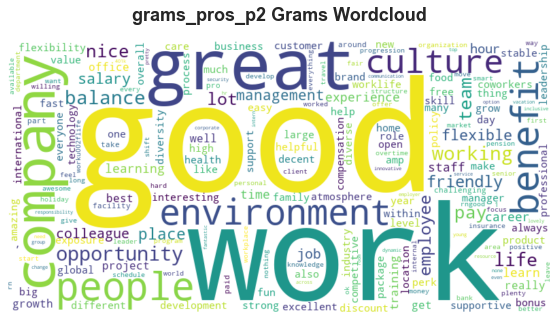

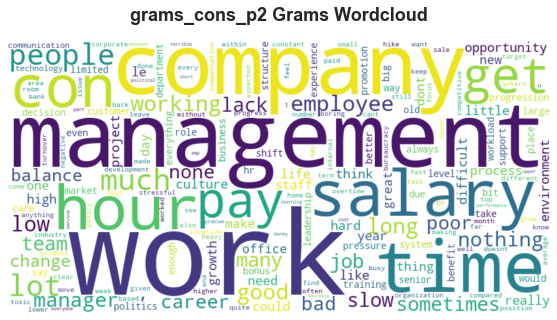

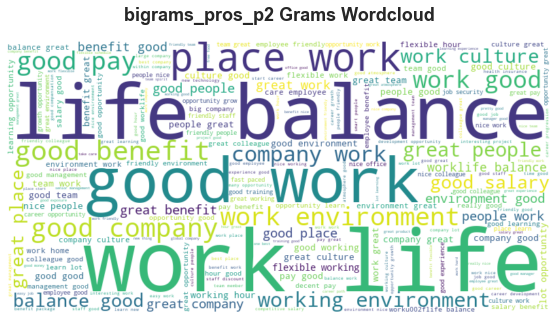

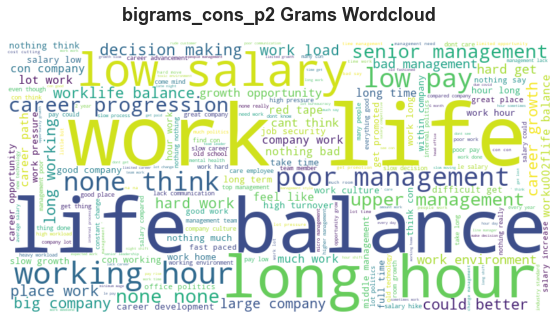

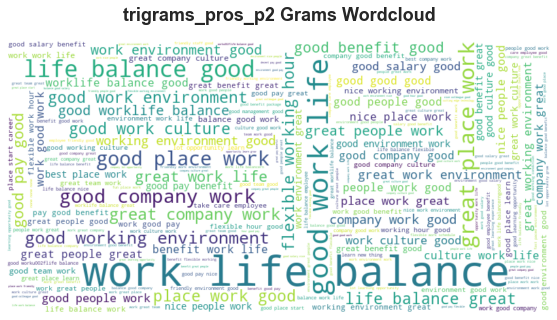

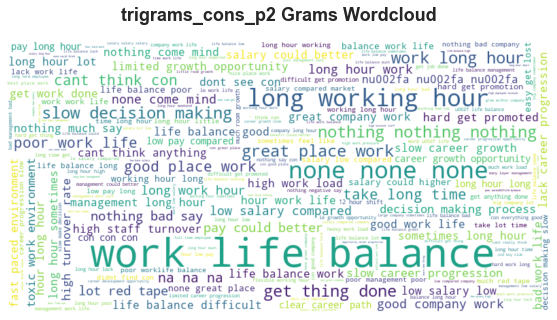

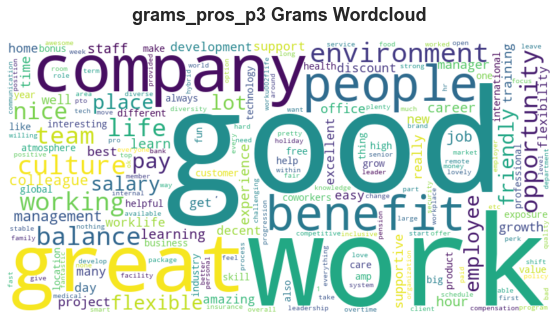

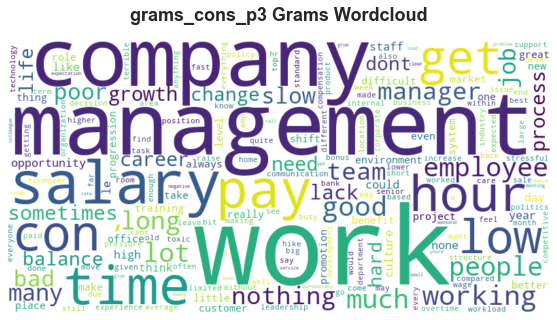

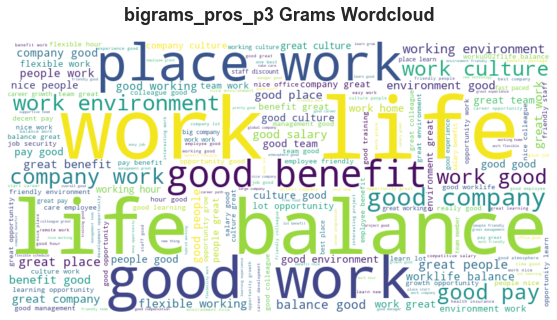

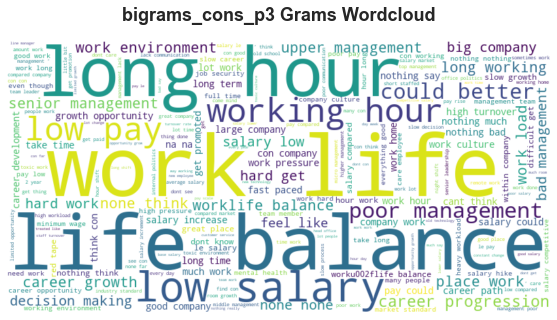

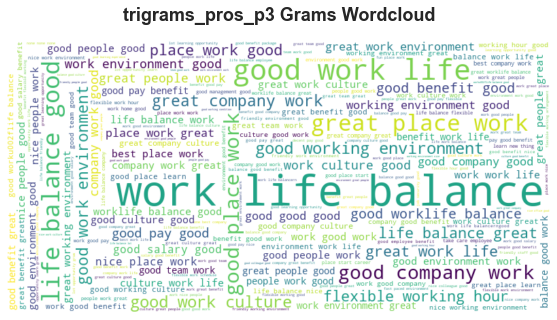

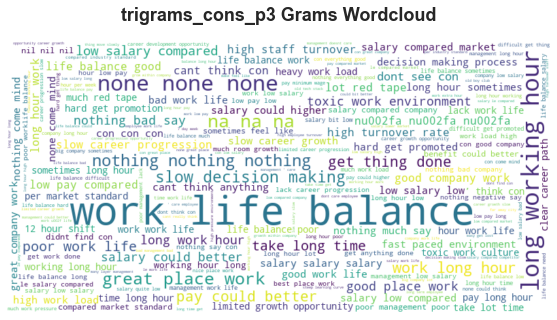

In [55]:
# Function to plot wordcloud
def plot_wordcloud(data, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white')
    wordcloud.generate_from_frequencies(dict(data))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Create grams and bigrams wordclouds for pros
def list_to_wordcloud(plot_name, grams):
    grams_dict = dict()
    for gram in grams:
        gram_str = ' '.join(gram)  # Convert the tuple to a string
        if gram_str in grams_dict:
            grams_dict[gram_str] += 1
        else:
            grams_dict[gram_str] = 1
    
    plot_wordcloud(grams_dict, f'{plot_name} Grams Wordcloud')
    return grams_dict

all_grams_counts = dict()
for key, value in all_grams.items():
    all_grams_counts[f'{key}_counts'] = list_to_wordcloud(key, value)
    
#dans text gram et le reste en appendix

In [56]:
import collections

# Get the 500 most frequent words
top500_grams_counts = dict()
for key, value in all_grams_counts.items():
    top500_grams_counts[key] = dict(collections.Counter(value).most_common(250))

In [57]:
# Select the grams for the lasso regression
# Let's not use the unigrams as they never mean much
unique_grams = set()
unigrams = ('grams_pros_p1_counts', 
              'grams_cons_p1_counts',
              'grams_pros_p2_counts', 
              'grams_cons_p2_counts',
              'grams_pros_p3_counts', 
              'grams_cons_p3_counts')

for key, counts in top500_grams_counts.items():
    if key not in unigrams:
        for gram_name in counts.keys():
            unique_grams.add(gram_name)

In [58]:
selected_grams = list(unique_grams)
len(selected_grams)

1204

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

In [60]:
# ## Best param is 0.0001
# from sklearn.model_selection import GridSearchCV
# param_grid = {'alpha': [0.001 ,0.0001, 0.005]}  
# lasso = Lasso()
# grid_search = GridSearchCV(lasso, param_grid, cv=2)
# grid_search.fit(X_train, y_train)
# best_params = grid_search.best_params_


In [61]:
# # Initialize CountVectorizer with selected grams
# vectorizer = CountVectorizer(ngram_range=(2, 3), vocabulary=selected_grams)

# # Transform pros and cons text into occurrence counts
# pros_counts = vectorizer.fit_transform(text['pros_lemma'])
# cons_counts = vectorizer.fit_transform(text['cons_lemma'])

# # Concatenate pros and cons occurrence counts, multiplying cons by -1
# X = pd.concat([pd.DataFrame(pros_counts.toarray()), pd.DataFrame(cons_counts.toarray() * -1)], axis=1)

# # Assign the rating column as the target variable
# y = text['rating']

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Initialize Lasso model with alpha value
# lasso = Lasso(alpha=0.0001)

# # Fit the Lasso model on the training data
# lasso.fit(X_train, y_train)

# # Predict ratings using the trained model
# y_pred = lasso.predict(X_test)

# # Calculate mean squared error to evaluate the model's performance
# mse = mean_squared_error(y_test, y_pred)

In [62]:
# mse

In [63]:
# # Get the feature names from the vectorizer
# feature_names = vectorizer.get_feature_names()

# # Get the coefficients from the Lasso model
# coefficients = lasso.coef_

# # Create a dictionary mapping feature names to coefficients
# feature_coefficients = dict(zip(feature_names, coefficients))

# # Create a DataFrame from the feature_coefficients dictionary
# df_coefficients = pd.DataFrame.from_dict(feature_coefficients, orient='index', columns=['Coefficient'])

# # Set the index name of the DataFrame as 'Feature'
# df_coefficients.index.name = 'Feature'

# # Filter the DataFrame to include only non-zero coefficient features
# df_valuable_coeffs = df_coefficients[df_coefficients['Coefficient'] != 0]

In [64]:
# file_path = 'important_features.pickle'
# # # Write pickle
# # with open(file_path, 'wb') as f:
# #     pickle.dump(df_valuable_coeffs, f)
# # # Read pickle
# with open(file_path, 'rb') as f:
#     df_valuable_coeffs = pickle.load(f)
# #df_valuable_coeffs = df_valuable_coeffs[~df_valuable_coeffs.index.isin(meaningless)]

In [65]:
# # Ok but let's see which are significant with an OLS approximation
# import statsmodels.api as sm

# # Initialize CountVectorizer with only valuable features
# vectorizer = CountVectorizer(ngram_range=(2, 3), vocabulary=df_valuable_coeffs.index)

# # Transform pros and cons text into occurrence counts
# pros_counts = vectorizer.fit_transform(text['pros_lemma'])
# cons_counts = vectorizer.fit_transform(text['cons_lemma'])

# # Concatenate pros and cons occurrence counts, multiplying cons by -1
# X = pd.concat([pd.DataFrame(pros_counts.toarray()), pd.DataFrame(cons_counts.toarray() * -1)], axis=1)

# # Assign the rating column as the target variable
# y = text['rating']

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Reset the indices of X_train and y_train to ensure alignment
# X_train.reset_index(drop=True, inplace=True)
# y_train.reset_index(drop=True, inplace=True)

# ols = sm.OLS(y_train, sm.add_constant(X_train))
# ols_results = ols.fit()

# p_values = ols_results.pvalues

In [66]:
# # Convert p-values to percentages with two decimal places
# p_values_pros_perc = p_values[1:331] * 100
# p_values_cons_perc = p_values[331:] * 100

# # Create a DataFrame for the gram names, coefficients, and p-values
# result_df = pd.DataFrame({'Gram': vectorizer.get_feature_names_out(),
#                           'Coefficient pros': ols_results.params[1:331].values,
#                           'Coefficient cons': ols_results.params[331:].values,
#                           'p-value_pros': p_values_pros_perc.values,
#                           'p-value_cons': p_values_cons_perc.values,
#                           'lasso coefficient': df_valuable_coeffs['Coefficient']})

# # Format p-values as percentages with two decimal places
# result_df['p-value_pros'] = result_df['p-value_pros'].map("{:.2f}%".format)
# result_df['p-value_cons'] = result_df['p-value_cons'].map("{:.2f}%".format)

In [67]:
file_path = 'important_featuress.pickle'
# # Write pickle
# with open(file_path, 'wb') as f:
#     pickle.dump(result_df, f)
# #Read pickle
with open(file_path, 'rb') as f:
    result_df = pickle.load(f)
    
# Convert str to float columns
def strToFloat(perc):
    return float(perc[:-1]) / 100
result_df['p-value_pros'] = result_df['p-value_pros'].apply(strToFloat)
result_df['p-value_cons'] = result_df['p-value_cons'].apply(strToFloat)

In [68]:
meaningless = ['dont want', 'good good', 'think anything', 'nothing nothing', 'na na', 'none none', 'dont get', 'none think', 'nothing think', 'much say', 'nothing much', 'cant think', 'come mind', 
              'none really', 'nothing say', 'nothing really', 'none really', 'nothing mention']

In [69]:
result_df = result_df[~result_df.index.isin(meaningless)]

In [70]:
result_df

Gram  Coefficient pros  \
Feature                                                                
great good                              great good          0.227875   
good salary                            good salary          0.149069   
good people good                  good people good          0.222205   
new employee                          new employee          0.238735   
good working environment  good working environment         -0.148566   
...                                            ...               ...   
good experience                    good experience          0.054251   
people nice                            people nice         -0.170188   
work place                              work place          0.196165   
great brand                            great brand         -0.079957   
leadership team                    leadership team          0.464063   

                          Coefficient cons  p-value_pros  p-value_cons  \
Feature                                                                  
great good                       -0.024348        0.0019        0.9281   
good salary                       0.099630        0.0000        0.0811   
good people good                 -0.599481        0.0000        0.0576   
new employee                      0.548092        0.0025        0.0000   
good working environment         -0.601503        0.0000        0.0029   
...                                    ...           ...           ...   
good experience                  -0.299319        0.0396        0.0000   
people nice                       0.222810        0.0000        0.1228   
work place                        0.293912        0.0000        0.0000   
great brand                       0.231263        0.0676        0.4384   
leadership team                   0.665428        0.0000        0.0000   

                          lasso coefficient  
Feature                                      
great good                         0.040060  
good salary                        0.117199  
good people good                   0.131001  
new employee                       0.007838  
good working environment          -0.062489  
...                                     ...  
good experience                    0.034365  
people nice                       -0.083874  
work place                         0.151933  
great brand                       -0.001313  
leadership team                    0.373000  

[313 rows x 6 columns]

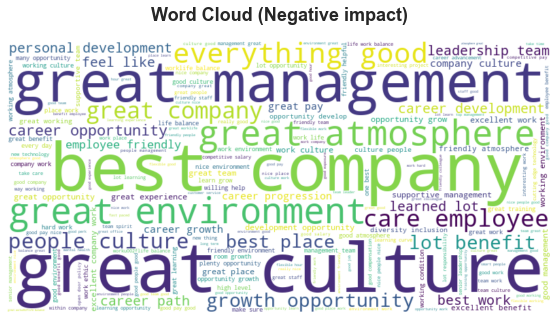

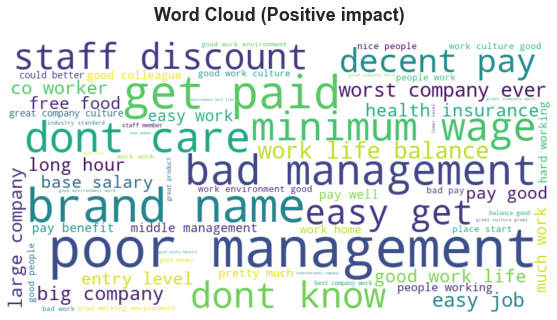

In [71]:
# Filter positive coefficients
positive_coeffs = result_df[(result_df['p-value_pros'] < 0.05) & (result_df['lasso coefficient'] > 0)]['lasso coefficient']

# Filter negative coefficients
negative_coeffs = result_df[(result_df['p-value_cons'] < 0.05) & (result_df['lasso coefficient'] < 0)]['lasso coefficient']

# Normalize positive coefficient sizes
positive_sizes = positive_coeffs.abs() / positive_coeffs.abs().max()

# Normalize negative coefficient sizes
negative_sizes = negative_coeffs.abs() / negative_coeffs.abs().max()

# Create word cloud for positive coefficients
positive_wordcloud = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(positive_sizes)
plt.figure(figsize=(10, 5))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud (Negative impact)')
plt.savefig('pros_lasso.png')
plt.show()

# Create word cloud for negative coefficients
negative_wordcloud = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(negative_sizes)
plt.figure(figsize=(10, 5))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud (Positive impact)')
plt.savefig('cons_lasso.png')
plt.show()

#dans le texte

## TWFE

In [72]:
# #specification: Exclude former employees for one and not for the other
# Roic our roe comme endo
# Rd intensity
# Cash ratio
# Halo score + subscore or overall review 
# ln(nbr employees) 
# book to market ratio
# ln(salaries)
# lag endo
# multiplier le score par dummies?


# def get_period(date):
#     if datetime(2021, 8, 1) >= date >= datetime(2020, 3, 18):
#         return 2
#     elif datetime(2021, 8, 1) < date:
#         return 3
#     else:
#         return 1

In [73]:
# for col in orbis_gd.columns:
#     print(col)

In [74]:
def get_roic(row):
    if row['period'] == 1:
        return (row['roic19'] + row['roic18'])/2
    elif row['period'] == 2:
        return (row['roic20'] + row['roic21'])/2
    elif row['period'] == 3:
        return row['roic22_y']
    
def get_roic_lag(row):
    if row['period'] == 1:
        return row['roic17']
    elif row['period'] == 2:
        return (row['roic19'] + row['roic18'])/2
    elif row['period'] == 3:
        return (row['roic20'] + row['roic21'])/2

def get_roic_growth(row):
    if row['period'] == 1:
        return ((row['roic19'] + row['roic18'])/2 - row['roic17'])/row['roic17']
    elif row['period'] == 2:
        return ((row['roic20'] + row['roic21'])/2 - (row['roic19'] + row['roic18'])/2)/((row['roic19'] + row['roic18'])/2)
    elif row['period'] == 3:
        return (row['roic22_y'] - (row['roic20'] + row['roic21'])/2)/((row['roic20'] + row['roic21'])/2)
    
def get_rd_intensity(row):
    if row['period'] == 1:
        return (row['R&D19']/row['total_assets19'] + row['R&D18']/row['total_assets18'])/2
    elif row['period'] == 2:
        return (row['R&D20']/row['total_assets20'] + row['R&D21']/row['total_assets21'])/2
    elif row['period'] == 3:
        return row['R&D22_y']/row['total_assets22_y']
    
def get_rd_debt_to_equity(row):
    if row['period'] == 1:
        return (row['R&D19']/row['total_assets19'] + row['R&D18']/row['total_assets18'])/2
    elif row['period'] == 2:
        return (row['R&D20']/row['total_assets20'] + row['R&D21']/row['total_assets21'])/2
    elif row['period'] == 3:
        return row['R&D22_y']/row['total_assets22_y']
    
def get_roa(row):
    if row['period'] == 1:
        return (row['roa19']+row['roa18'])/2
    elif row['period'] == 2:
        return (row['roa20'] + row['roa20'])/2
    elif row['period'] == 3:
        return row['roa22_y']

def get_roa_lag(row):
    if row['period'] == 1:
        return row['roa17']
    elif row['period'] == 2:
        return (row['roa19']+row['roa18'])/2
    elif row['period'] == 3:
        return (row['roa20']+row['roa21'])/2
    
def get_roa_growth(row):
    if row['period'] == 1:
        return ((row['roa19'] + row['roa18'])/2 - row['roa17'])/row['roa17']
    elif row['period'] == 2:
        return ((row['roa20'] + row['roa21'])/2 - (row['roa19'] + row['roa18'])/2)/((row['roa19'] + row['roa18'])/2)
    elif row['period'] == 3:
        return (row['roa22_y'] - (row['roa20'] + row['roa21'])/2)/((row['roa20'] + row['roa21'])/2)
    
def get_cash_ratio(row):
    if row['period'] == 1:
        return (row['cash_and_cash19']/row['total_assets19'] + row['cash_and_cash18']/row['total_assets18'])/2
    elif row['period'] == 2:
        return (row['cash_and_cash20']/row['total_assets20'] + row['cash_and_cash21']/row['total_assets21'])/2
    elif row['period'] == 3:
        return row['cash_and_cash22_y']/row['total_assets22_y']
    
def get_ln_employees(row):
    if row['period'] == 1:
        return np.log((row['nbr_employees19']+row['nbr_employees18'])/2)
    elif row['period'] == 2:
        return np.log((row['nbr_employees20']+row['nbr_employees21'])/2)
    elif row['period'] == 3: 
        return np.log(row['nbr_employees22_y'])
    
def get_ln_salaries(row):
    if row['period'] == 1:
        return np.log((row['salaries19']/row['nbr_employees19']+row['salaries18']/row['nbr_employees18'])/2)
    elif row['period'] == 2:
        return np.log((row['salaries20']/row['nbr_employees20']+row['salaries21']/row['nbr_employees21'])/2)
    elif row['period'] == 3:
        return np.log(row['salaries22_y']/row['nbr_employees22_y'])
    
def get_book_to_market(row):
    if row['period'] == 1:
        return np.log((row['shareholder19']/row['market_cap19'] + row['shareholder18']/row['market_cap18'])/2)
    elif row['period'] == 2:
        return np.log((row['shareholder20']/row['market_cap20'] + row['shareholder21']/row['market_cap21'])/2)
    elif row['period'] == 3:
        return np.log(row['shareholder22_y']/row['market_cap22_y'])

def get_halo_score(pros, cons):
    return np.log(len(str(pros))/len(str(cons)))

def get_period_dummy1(row):
    if row['period'] == 1:
        return 1
    else:
        return 0

def get_period_dummy2(row):
    if row['period'] == 2:
        return 1
    else:
        return 0

def get_period_dummy3(row):
    if row['period'] == 3:
        return 1
    else:
        return 0
    
def get_de(row):
    if row['period'] == 1:
        return (row['debt_to_equity18']+row['debt_to_equity19'])/2
    elif row['period'] == 2:
        return (row['debt_to_equity20']+row['debt_to_equity21'])/2
    elif row['period'] == 3: 
        return row['debt_to_equity22_y']

In [77]:
# # Apply the get_roic function
# orbis_gd['roic'] = orbis_gd.apply(get_roic, axis=1)

# # Apply the get_roic_lag function
# orbis_gd['roic_lag'] = orbis_gd.apply(get_roic_lag, axis=1)

# #Apply the get_roic_lag function
# orbis_gd['roic_growth'] = orbis_gd.apply(get_roic_growth, axis=1)

# # Apply the get_rd_intensity function
# orbis_gd['rd_intensity'] = orbis_gd.apply(get_rd_intensity, axis=1)

# # Apply the get_roe function
# orbis_gd['roa'] = orbis_gd.apply(get_roa, axis=1)

# # Apply the get_roe_lag function
# orbis_gd['roa_lag'] = orbis_gd.apply(get_roa_lag, axis=1)

# # Apply the get_roe_lag function
# orbis_gd['roa_growth'] = orbis_gd.apply(get_roa_growth, axis=1)

# # Apply the get_cash_ratio function
# orbis_gd['cash_ratio'] = orbis_gd.apply(get_cash_ratio, axis=1)

# # Apply the get_ln_employees function
# orbis_gd['ln_employees'] = orbis_gd.apply(get_ln_employees, axis=1)

# # Apply the get_ln_salaries function
# orbis_gd['ln_salaries'] = orbis_gd.apply(get_ln_salaries, axis=1)

# # Apply the get_book_to_market function
# orbis_gd['book_to_market'] = orbis_gd.apply(get_book_to_market, axis=1)

# # Apply the get_halo_score function (Assuming you have "pros" and "cons" columns in your DataFrame)
# orbis_gd['halo_score'] = orbis_gd.apply(lambda row: get_halo_score(row['pros'], row['cons']), axis=1)

# # Apply the get_period_dummy1 function
# orbis_gd['period_dummy1'] = orbis_gd.apply(get_period_dummy1, axis=1)

# # Apply the get_period_dummy1 function
# orbis_gd['period_dummy2'] = orbis_gd.apply(get_period_dummy2, axis=1)

# # Apply the get_period_dummy2 function
# orbis_gd['period_dummy3'] = orbis_gd.apply(get_period_dummy3, axis=1)

# # Apply the get_period_dummy2 function
# orbis_gd['debt_to_equity'] = orbis_gd.apply(get_de, axis=1)

In [78]:
# Growth vs lag (wang 2015 table 7 uses lag, in jounral in corpo finance donc paper solide.
# Methode malka , controle pour la croissande du roic.
# Control for roic growth, a un beta negatif parce que une resultat positif est suivi par un genre de normalisation

# Variables financiers
# rde, cahs ratio, employees, book to market, add leverage


# interpretation des changement de beta avec controles
# roa vs roic
# presentation stargazer
# rapport de stage format 
# sans periode 2

In [79]:
import statsmodels.api as sm
from stargazer.stargazer import Stargazer

In [80]:
twfe_df = orbis_gd[['orbis_name',
                    'bvd_sector',
                    'period', 
                    'is_current_job', 
                    'review_overall', 
                    'roic', 
                    'roic_lag',
                    'roic_growth',
                    'rd_intensity',
                    'roa',
                    'roa_lag',
                    'cash_ratio',
                    'ln_employees',
                    'ln_salaries',
                    'book_to_market',
                    'halo_score',
                    'debt_to_equity',
                    'period_dummy1',
                    'period_dummy2',
                    'period_dummy3']]
                    # 'rating_worklifebalance',
                    # 'rating_culture_values',
                    # 'rating_diversity_inclusion',
                    # 'rating_senior_leadership',
                    # 'rating_career_opport',
                    # 'rating_compensation_benefits',
                    # 'rating_recommend_friend']]

# Creating dummy variables for the 'period' variable
period_dummies = pd.get_dummies(twfe_df['period'], drop_first=True, prefix='period')

# Creating dummy variables for the 'bvd_sector' variable
sector_dummies = pd.get_dummies(twfe_df['bvd_sector'], drop_first=True, prefix='sector')

# Concatenate the dummy variables with the original DataFrame
twfe_df = pd.concat([twfe_df, period_dummies, sector_dummies], axis=1)

twfe_df = twfe_df.dropna()

In [81]:
# bc it'[s sticky, good to control for lag
# Roa would have had the same isssue as roic, another way would have been market returns but it's mostly market dependent instead of company dependent

In [82]:
# with book to market you control for high growth, high investment companies and book to market and r&d should be highly correlated, show with correlation

In [112]:
twfe_df['review_p2'] = twfe_df['review_overall'] * twfe_df['period_2']
twfe_df['review_p3'] = twfe_df['review_overall'] * twfe_df['period_3']


# Performing the regression of 'roic' on 'review_overall'
X = sm.add_constant(twfe_df['review_overall']) 
y = twfe_df['roic']
model1 = sm.OLS(y, X).fit()

X = sm.add_constant(twfe_df[['review_overall', 'period_2', 'period_3'] + list(sector_dummies.columns)])  
y = twfe_df['roic']
model2 = sm.OLS(y, X).fit()

X = sm.add_constant(twfe_df[['review_overall', 'review_p2', 'review_p3', 'period_2', 'period_3'] + list(sector_dummies.columns)]) 
y = twfe_df['roic']
model3 = sm.OLS(y, X).fit()

X = sm.add_constant(twfe_df[['review_overall', 'review_p2', 'review_p3', 'period_2', 'period_3', 'debt_to_equity'] + list(sector_dummies.columns)])  # Add constant for intercept term
y = twfe_df['roic']
model4 = sm.OLS(y, X).fit()

X = sm.add_constant(twfe_df[['review_overall', 'review_p2', 'review_p3', 'period_2', 'period_3', 'debt_to_equity', 'book_to_market'] + list(sector_dummies.columns)])  # Add constant for intercept term
y = twfe_df['roic']
model5 = sm.OLS(y, X).fit()

X = sm.add_constant(twfe_df[['review_overall', 'review_p2', 'review_p3', 'period_2', 'period_3', 'debt_to_equity', 'book_to_market', 'rd_intensity'] + list(sector_dummies.columns)])  # Add constant for intercept term
y = twfe_df['roic']
model6 = sm.OLS(y, X).fit()

X = sm.add_constant(twfe_df[['review_overall', 'review_p2', 'review_p3', 'period_2', 'period_3', 'debt_to_equity', 'book_to_market', 'rd_intensity', 'ln_employees'] + list(sector_dummies.columns)])  # Add constant for intercept term
y = twfe_df['roic']
model7 = sm.OLS(y, X).fit()

X = sm.add_constant(twfe_df[['review_overall', 'review_p2', 'review_p3', 'period_2', 'period_3', 'debt_to_equity', 'rd_intensity', 'cash_ratio', 'ln_employees', 'book_to_market'] + list(sector_dummies.columns)])  # Add constant for intercept term
y = twfe_df['roic']
model8 = sm.OLS(y, X).fit()


stargazer_tab = Stargazer([model1, model2, model3, model4, model5, model6, model7, model8])
stargazer_tab.rename_covariates({'review_overall': 'Rating',
                                 'period_2': 'Dummy period 2',
                                 'period_3': 'Dummy period 3',
                                 'review_p2': 'Dummy p2 x Rating',
                                 'review_p3': 'Dummy p3 x Rating',
                                 #'roic_growth': 'ROIC Growth rate',
                                 'rd_intensity': 'R\&D intensity',
                                 'cash_ratio': 'Cash ratio',
                                 'ln_employees': '#Employees',
                                 'book_to_market': 'Book to Market',
                                 'debt_to_equity':'Debt to Equity'})
stargazer_tab.covariate_order(['review_overall', 'period_2', 'period_3', 'review_p2', 'review_p3', 'debt_to_equity', 'book_to_market', 'rd_intensity', 'ln_employees', 'cash_ratio'])
stargazer_tab.add_line('Sector control', ['No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes'])
stargazer_tab.title('Base regression')
open('base_reg.tex', 'w').write(stargazer_tab.render_latex())  # for latex

stargazer_tab

In [106]:
# Performing the regression of 'roic' on 'review_overall'
X = sm.add_constant(twfe_df[['review_overall', 'review_p2', 'review_p3', 'period_2', 'period_3', 'rd_intensity', 'cash_ratio', 'ln_employees', 'book_to_market', 'debt_to_equity'] + list(sector_dummies.columns)])  # Add constant for intercept term
y = twfe_df['roic']
model1 = sm.OLS(y, X).fit()

X = sm.add_constant(twfe_df[['review_overall', 'review_p2', 'review_p3', 'period_2', 'period_3', 'rd_intensity', 'cash_ratio', 'ln_employees', 'book_to_market', 'debt_to_equity'] + list(sector_dummies.columns)])  # Add constant for intercept term
y = twfe_df['roa']
model2 = sm.OLS(y, X).fit()

stargazer_tab = Stargazer([model1, model2])
stargazer_tab.rename_covariates({'review_overall': 'Rating',
                                 'period_2': 'Dummy period 2',
                                 'period_3': 'Dummy period 3',
                                 'review_p2': 'Dummy p2 x Rating',
                                 'review_p3': 'Dummy p3 x Rating',
                                 #'roa_lag': 'ROA lag',
                                 #'roic_lag': 'ROIC lag',
                                 'rd_intensity': 'R\&D intensity',
                                 'cash_ratio': 'Cash ratio',
                                 'ln_employees': '#Employees',
                                 'book_to_market': 'Book to Market',
                                 'debt_to_equity':'Debt to Equity'})
stargazer_tab.covariate_order(['review_overall', 'period_2', 'period_3', 'review_p2', 'review_p3', 'rd_intensity', 'cash_ratio', 'ln_employees', 'book_to_market', 'debt_to_equity'])
stargazer_tab.add_line('Sector control', ['Yes', 'Yes'])
stargazer_tab.title('ROA robustness check')
open('roa_roic_reg.tex', 'w').write(stargazer_tab.render_latex())  # for latex

stargazer_tab

In [107]:
twfe_df_current = twfe_df[twfe_df['is_current_job'] == True]

X = sm.add_constant(twfe_df[['review_overall', 'review_p2', 'review_p3', 'period_2', 'period_3', 'rd_intensity', 'cash_ratio', 'ln_employees', 'book_to_market', 'debt_to_equity'] + list(sector_dummies.columns)])  # Add constant for intercept term
y = twfe_df['roic']
model1 = sm.OLS(y, X).fit()

X = sm.add_constant(twfe_df_current[['review_overall', 'review_p2', 'review_p3', 'period_2', 'period_3', 'rd_intensity', 'cash_ratio', 'ln_employees', 'book_to_market', 'debt_to_equity'] + list(sector_dummies.columns)])  # Add constant for intercept term
y = twfe_df_current['roic']
model2 = sm.OLS(y, X).fit()

stargazer_tab = Stargazer([model1, model2])
stargazer_tab.rename_covariates({'review_overall': 'Rating',
                                 'period_2': 'Dummy period 2',
                                 'period_3': 'Dummy period 3',
                                 'review_p2': 'Dummy p2 x Rating',
                                 'review_p3': 'Dummy p3 x Rating',
                                 #'roic_growth': 'ROIC Growth rate',
                                 'rd_intensity': 'R\&D intensity',
                                 'cash_ratio': 'Cash ratio',
                                 'ln_employees': '#Employees',
                                 'book_to_market': 'Book to Market',
                                 'debt_to_equity':'Debt to Equity'})
stargazer_tab.covariate_order(['review_overall', 'period_2', 'period_3', 'review_p2', 'review_p3', 'rd_intensity', 'cash_ratio', 'ln_employees', 'book_to_market', 'debt_to_equity'])
stargazer_tab.add_line('Sector control', ['Yes', 'Yes'])
stargazer_tab.title('Only current employees robustness check')
open('is_current_reg.tex', 'w').write(stargazer_tab.render_latex())  # for latex


stargazer_tab

In [108]:
# Performing the regression of 'roic' on 'review_overall'
twfe_df_nop2 = twfe_df[twfe_df['period'] != 2]

X = sm.add_constant(twfe_df[['review_overall', 'review_p2', 'review_p3', 'period_2', 'period_3', 'rd_intensity', 'cash_ratio', 'ln_employees', 'book_to_market', 'debt_to_equity'] + list(sector_dummies.columns)])  # Add constant for intercept term
y = twfe_df['roic']
model1 = sm.OLS(y, X).fit()

X = sm.add_constant(twfe_df_nop2[['review_overall', 'review_p3', 'period_3', 'rd_intensity', 'cash_ratio', 'ln_employees', 'book_to_market', 'debt_to_equity'] + list(sector_dummies.columns)])  # Add constant for intercept term
y = twfe_df_nop2['roic']
model2 = sm.OLS(y, X).fit()

stargazer_tab = Stargazer([model1, model2])
stargazer_tab.rename_covariates({'review_overall': 'Rating',
                                 'period_2': 'Dummy period 2',
                                 'period_3': 'Dummy period 3',
                                 'review_p2': 'Dummy p2 x Rating',
                                 'review_p3': 'Dummy p3 x Rating',
                                 #'roic_growth': 'ROIC Growth rate',
                                 'rd_intensity': 'R\&D intensity',
                                 'cash_ratio': 'Cash ratio',
                                 'ln_employees': '#Employees',
                                 'book_to_market': 'Book to Market',
                                 'debt_to_equity':'Debt to Equity'})
stargazer_tab.covariate_order(['review_overall', 'period_2', 'period_3', 'review_p2', 'review_p3', 'rd_intensity', 'cash_ratio', 'ln_employees', 'book_to_market', 'debt_to_equity'])
stargazer_tab.add_line('Sector control', ['Yes', 'Yes'])
stargazer_tab.title('No period 2 robustness check')
open('nop2.tex', 'w').write(stargazer_tab.render_latex())  # for latex

stargazer_tab

In [110]:
twfe_df_ratings = orbis_gd[['orbis_name',
                    'bvd_sector',
                    'period', 
                    'is_current_job', 
                    'review_overall', 
                    'roic', 
                    'roic_lag',
                    'roic_growth',
                    'rd_intensity',
                    'roa',
                    'roa_lag',
                    'cash_ratio',
                    'ln_employees',
                    'ln_salaries',
                    'book_to_market',
                    'halo_score',
                    'debt_to_equity',
                    'period_dummy1',
                    'period_dummy2',
                    'period_dummy3',
                    'rating_worklifebalance',
                    'rating_culture_values',
                    'rating_senior_leadership',
                    'rating_career_opport',
                    'rating_compensation_benefits',
                    'rating_recommend_friend']]


# Creating dummy variables for the 'period' variable
period_dummies = pd.get_dummies(twfe_df_ratings['period'], drop_first=True, prefix='period')

# Creating dummy variables for the 'bvd_sector' variable
sector_dummies = pd.get_dummies(twfe_df_ratings['bvd_sector'], drop_first=True, prefix='sector')

# Concatenate the dummy variables with the original DataFrame
twfe_df_other = pd.concat([twfe_df_ratings, period_dummies, sector_dummies], axis=1)

twfe_df_other = twfe_df_other.dropna()

twfe_df_other['work_p2'] = twfe_df_other['rating_worklifebalance'] * twfe_df_other['period_2']
twfe_df_other['work_p3'] = twfe_df_other['rating_worklifebalance'] * twfe_df_other['period_3']
twfe_df_other['culture_p2'] = twfe_df_other['rating_culture_values'] * twfe_df_other['period_2']
twfe_df_other['culture_p3'] = twfe_df_other['rating_culture_values'] * twfe_df_other['period_3']
twfe_df_other['lead_p2'] = twfe_df_other['rating_senior_leadership'] * twfe_df_other['period_2']
twfe_df_other['lead_p3'] = twfe_df_other['rating_senior_leadership'] * twfe_df_other['period_3']
twfe_df_other['career_p2'] = twfe_df_other['rating_career_opport'] * twfe_df_other['period_2']
twfe_df_other['career_p3'] = twfe_df_other['rating_career_opport'] * twfe_df_other['period_3']
twfe_df_other['comp_p2'] = twfe_df_other['rating_compensation_benefits'] * twfe_df_other['period_2']
twfe_df_other['comp_p3'] = twfe_df_other['rating_compensation_benefits'] * twfe_df_other['period_3']
twfe_df_other['friend_p2'] = twfe_df_other['rating_recommend_friend'] * twfe_df_other['period_2']
twfe_df_other['friend_p3'] = twfe_df_other['rating_recommend_friend'] * twfe_df_other['period_3']


X = sm.add_constant(twfe_df[['review_overall', 'review_p2', 'review_p3', 'period_2', 'period_3', 'rd_intensity', 'cash_ratio', 'ln_employees', 'book_to_market', 'debt_to_equity'] + list(sector_dummies.columns)])  # Add constant for intercept term
y = twfe_df['roic']
model1 = sm.OLS(y, X).fit()

X = sm.add_constant(twfe_df_other[['rating_worklifebalance', 'work_p2', 'period_2', 'work_p3', 'period_3', 'halo_score', 'rd_intensity', 'cash_ratio', 'ln_employees', 'book_to_market', 'debt_to_equity'] + list(sector_dummies.columns)])  # Add constant for intercept term
y = twfe_df_other['roic']
model2 = sm.OLS(y, X).fit()

X = sm.add_constant(twfe_df_other[['rating_culture_values', 'culture_p2', 'period_2', 'culture_p3', 'period_3', 'halo_score', 'rd_intensity', 'cash_ratio', 'ln_employees', 'book_to_market', 'debt_to_equity'] + list(sector_dummies.columns)])  # Add constant for intercept term
y = twfe_df_other['roic']
model3 = sm.OLS(y, X).fit()

X = sm.add_constant(twfe_df_other[['rating_senior_leadership', 'lead_p2', 'period_2', 'lead_p3', 'period_3', 'halo_score', 'rd_intensity', 'cash_ratio', 'ln_employees', 'book_to_market', 'debt_to_equity'] + list(sector_dummies.columns)])  # Add constant for intercept term
y = twfe_df_other['roic']
model4 = sm.OLS(y, X).fit()

X = sm.add_constant(twfe_df_other[['rating_career_opport', 'career_p2', 'period_2', 'career_p3', 'period_3', 'halo_score', 'rd_intensity', 'cash_ratio', 'ln_employees', 'book_to_market', 'debt_to_equity'] + list(sector_dummies.columns)])  # Add constant for intercept term
y = twfe_df_other['roic']
model5 = sm.OLS(y, X).fit()

X = sm.add_constant(twfe_df_other[['rating_compensation_benefits', 'comp_p2', 'period_2', 'comp_p3', 'period_3', 'halo_score', 'rd_intensity', 'cash_ratio', 'ln_employees', 'book_to_market', 'debt_to_equity'] + list(sector_dummies.columns)])  # Add constant for intercept term
y = twfe_df_other['roic']
model6 = sm.OLS(y, X).fit()

X = sm.add_constant(twfe_df_other[['rating_recommend_friend', 'friend_p2', 'period_2', 'friend_p3', 'period_3', 'halo_score', 'rd_intensity', 'cash_ratio', 'ln_employees', 'book_to_market', 'debt_to_equity'] + list(sector_dummies.columns)])  # Add constant for intercept term
y = twfe_df_other['roic']
model7 = sm.OLS(y, X).fit()

stargazer_tab = Stargazer([model1, model2, model3, model4, model5, model6, model7])
stargazer_tab.rename_covariates({'halo_score': 'Halo score',
                                 'period_2': 'Dummy period 2',
                                 'period_3': 'Dummy period 3',
                                 'review_p2': 'Dummy p2 x Rating',
                                 'review_p3': 'Dummy p3 x Rating',
                                 'work_p2': 'Work life balance x Dummy period 2',
                                 'work_p3': 'Work life balance x Dummy period 3',
                                 'lead_p2': 'Senior leadership x Dummy period 2',
                                 'lead_p3': 'Senior leadership x Dummy period 3',
                                 'culture_p2': 'Culture \& values x Dummy period 2',
                                 'culture_p3': 'Culture \& values x Dummy period 3',
                                 'comp_p2': 'Comps \& benefits x Dummy period 2',
                                 'comp_p3': 'Comps \& benefits x Dummy period 3',
                                 'friend_p2': 'Recommend to friend x Dummy period 2',
                                 'friend_p3': 'Recommend to friend x Dummy period 3',
                                 'career_p2': 'Career opportunities x Dummy period 2',
                                 'career_p3': 'Career opportunities x Dummy period 3',
                                 #'roic_growth': 'ROIC Growth rate',
                                 'rd_intensity': 'R\&D intensity',
                                 'cash_ratio': 'Cash ratio',
                                 'ln_employees': '#Employees',
                                 'book_to_market': 'Book to Market',
                                 'debt_to_equity':'Debt to Equity'})
stargazer_tab.covariate_order([ 'period_2', 'period_3', 
                               'halo_score',
                               'review_p2', 'review_p3',
                               'work_p2', 'work_p3',
                               'culture_p2', 'culture_p3', 
                               'lead_p2', 'lead_p3', 
                               'career_p2', 'career_p3', 
                               'comp_p2', 'comp_p3', 
                               'friend_p2', 'friend_p3'])
stargazer_tab.add_line('Sector & financial control', ['Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes'])
stargazer_tab.title('Other sentiment ratings robustness checks')
open('other_ratings.tex', 'w').write(stargazer_tab.render_latex())  # for latex

stargazer_tab